In [ ]:
%pip install -r requirements.txt

In [17]:
import torch
from torch import nn

a = torch.randn(8, 64)
b = torch.randn(8, 64)

torch.cat((a, b), 1).shape

torch.Size([8, 128])

In [18]:
url = 
key =

In [19]:
import os
from supabase import create_client, Client
from datetime import date
import datetime

supabase: Client = create_client(url, key)

In [20]:
response = supabase.table('entries').select("*").execute()

In [21]:
response

APIResponse[~_ReturnT](data=[{'id': 1, 'created_at': '2024-04-27T05:18:25.063111+00:00', 'price': 4, 'area': 20, 'street': 'Bưởi', 'ward': 'Bưởi', 'district': 'Tây Hồ', 'post_date': '2024-04-26 08:30:00', 'url': 'https://bds123.vn/phong-day-du-tien-nghi-cho-thue-gan-ho-tay-2-pr647967.html', 'description': 'PHÒNG ĐẦY ĐỦ TIỆN NGHI CHO THUÊ - GẦN HỒ TÂY Địa chỉ: Số 27, ngõ 29 phố Võng Thị, Tây Hồ, Hà Nội (gần sát hồ Tây) Diện tích: từ 20m2 Giá thuê: từ 4,5 triệu/ tháng Tiện nghi đầy đủ: Giường, tủ lớn, bàn làm việc, TV, truyền hình cáp, internet tốc độ cao,... An ninh đảm bảo: Bảo vệ 24/7, khóa cổng vân tay, camera an ninh toàn bộ khu vực chung Giờ giấc tự do thoải mái, có hầm để xe Dịch vụ đầy đủ: Nước sinh hoạt, internet tốc độ cao, truyền hình cáp, quản lý tòa nhà hỗ trợ 24/7 Tầng thượng có khu BBQ view hồ Tây, thang máy kính view hồ Tây Giao thông thuận tiện, ô tô vào tận nhà Liên hệ: Minh - 09.4242.5656', 'num_bedroom': 0, 'num_diningroom': 0, 'num_kitchen': 0, 'num_toilet': 0, 'num_

In [22]:
response.data

[{'id': 1,
  'created_at': '2024-04-27T05:18:25.063111+00:00',
  'price': 4,
  'area': 20,
  'street': 'Bưởi',
  'ward': 'Bưởi',
  'district': 'Tây Hồ',
  'post_date': '2024-04-26 08:30:00',
  'url': 'https://bds123.vn/phong-day-du-tien-nghi-cho-thue-gan-ho-tay-2-pr647967.html',
  'description': 'PHÒNG ĐẦY ĐỦ TIỆN NGHI CHO THUÊ - GẦN HỒ TÂY Địa chỉ: Số 27, ngõ 29 phố Võng Thị, Tây Hồ, Hà Nội (gần sát hồ Tây) Diện tích: từ 20m2 Giá thuê: từ 4,5 triệu/ tháng Tiện nghi đầy đủ: Giường, tủ lớn, bàn làm việc, TV, truyền hình cáp, internet tốc độ cao,... An ninh đảm bảo: Bảo vệ 24/7, khóa cổng vân tay, camera an ninh toàn bộ khu vực chung Giờ giấc tự do thoải mái, có hầm để xe Dịch vụ đầy đủ: Nước sinh hoạt, internet tốc độ cao, truyền hình cáp, quản lý tòa nhà hỗ trợ 24/7 Tầng thượng có khu BBQ view hồ Tây, thang máy kính view hồ Tây Giao thông thuận tiện, ô tô vào tận nhà Liên hệ: Minh - 09.4242.5656',
  'num_bedroom': 0,
  'num_diningroom': 0,
  'num_kitchen': 0,
  'num_toilet': 0,
  'num_

In [23]:
import location

print(len(location.get_all_streets()))
print(len(location.get_all_wards()))
print(len(location.get_all_districts()))

1572
430
25


In [24]:
location.standardize_district_name("Hà Nội")

'Hà Nội'

In [25]:
def encode_street(street):
    street = location.standardize_street_name(street)
    if street not in location.get_all_streets():
        return -1
    street_encoded = location.get_all_streets().index(street)
    
    return street_encoded

def encode_ward(ward):
    ward = location.standardize_ward_name(ward)
    if ward not in location.get_all_wards():
        return -1
    ward_encoded = location.get_all_wards().index(ward)
    
    return ward_encoded

def encode_district(district):
    district = location.standardize_district_name(district)
    if district not in location.get_all_districts():
        return -1
    district_encoded = location.get_all_districts().index(district)
    
    return district_encoded

encode_street("Đại La")
encode_ward("Trương Định")
encode_district("Hai Ba Trung")

7

In [26]:
location.get_district_from_ward("Trương Định")

'Hai Bà Trưng'

In [27]:
datas = []
for data in response.data:
    if encode_street(data["street"]) == -1:
        continue
    if encode_ward(data["ward"]) == -1:
        continue
    if encode_district(data["district"]) == -1:
        data["district"] = location.get_district_from_ward(data["ward"])
        if data["district"]:
            print(data["district"])
            datas.append(data)
            continue
    datas.append(data)

datas

Đống Đa
Đống Đa
Đống Đa
Đống Đa
Đống Đa
Đống Đa
Đống Đa
Đống Đa
Đống Đa
Thường Tín
Hoàn Kiếm
Đống Đa
Đống Đa
Đống Đa
Ba Đình
Thanh Xuân
Đống Đa
Đống Đa
Đống Đa
Đống Đa
Đống Đa
Đống Đa
Đống Đa
Đống Đa
Đống Đa
Đống Đa
Đống Đa
Đống Đa
Đống Đa
Đống Đa
Đống Đa
Đống Đa
Đống Đa
Đống Đa
Đống Đa
Đống Đa
Đống Đa
Thường Tín
Hoàn Kiếm
Thanh Xuân
Thanh Xuân
Hoàn Kiếm
Thanh Xuân
Thanh Xuân
Thanh Xuân
Thanh Xuân
Thanh Xuân
Hoàn Kiếm
Thanh Xuân
Thanh Xuân
Hoàn Kiếm
Thường Tín
Thanh Xuân
Hoàn Kiếm
Thanh Xuân
Thanh Xuân
Ba Đình
Thanh Xuân
Đống Đa
Đống Đa
Đống Đa
Đống Đa
Đống Đa
Đống Đa


[{'id': 1,
  'created_at': '2024-04-27T05:18:25.063111+00:00',
  'price': 4,
  'area': 20,
  'street': 'Bưởi',
  'ward': 'Bưởi',
  'district': 'Tây Hồ',
  'post_date': '2024-04-26 08:30:00',
  'url': 'https://bds123.vn/phong-day-du-tien-nghi-cho-thue-gan-ho-tay-2-pr647967.html',
  'description': 'PHÒNG ĐẦY ĐỦ TIỆN NGHI CHO THUÊ - GẦN HỒ TÂY Địa chỉ: Số 27, ngõ 29 phố Võng Thị, Tây Hồ, Hà Nội (gần sát hồ Tây) Diện tích: từ 20m2 Giá thuê: từ 4,5 triệu/ tháng Tiện nghi đầy đủ: Giường, tủ lớn, bàn làm việc, TV, truyền hình cáp, internet tốc độ cao,... An ninh đảm bảo: Bảo vệ 24/7, khóa cổng vân tay, camera an ninh toàn bộ khu vực chung Giờ giấc tự do thoải mái, có hầm để xe Dịch vụ đầy đủ: Nước sinh hoạt, internet tốc độ cao, truyền hình cáp, quản lý tòa nhà hỗ trợ 24/7 Tầng thượng có khu BBQ view hồ Tây, thang máy kính view hồ Tây Giao thông thuận tiện, ô tô vào tận nhà Liên hệ: Minh - 09.4242.5656',
  'num_bedroom': 0,
  'num_diningroom': 0,
  'num_kitchen': 0,
  'num_toilet': 0,
  'num_

In [28]:
len(datas), len(response.data)

(392, 416)

In [29]:
from sklearn.model_selection import train_test_split

train_data, valid_data = train_test_split(datas, test_size=0.3, random_state=42)

In [30]:
len(valid_data)

118

In [31]:
import numpy as np

list_area = [int(data["area"]) for data in train_data]

area_mean = np.mean(list_area)
area_std = np.std(list_area)

area_mean, area_std

(27.81021897810219, 8.39232604516763)

In [32]:
import torch
from torch.utils.data import Dataset, DataLoader

class RentDataset(Dataset):
    def __init__(self, supabase_response, area_mean=None, area_std=None):
       self.data = supabase_response
       self.area_mean = area_mean
       self.area_std = area_std
       
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        price = torch.Tensor([self.data[idx]["price"]])
        if self.area_mean:
            area = (self.data[idx]["area"] - self.area_mean) / self.area_std
        else:
            area = self.data[idx]["area"]
        
        street = encode_street(self.data[idx]["street"])
        ward = encode_ward(self.data[idx]["ward"])
        district = encode_district(self.data[idx]["district"])
        
        num_bedroom = self.data[idx]["num_bedroom"]
        num_diningroom = self.data[idx]["num_diningroom"]
        num_kitchen = self.data[idx]["num_kitchen"]
        num_toilet = self.data[idx]["num_toilet"]
        
        attr = torch.Tensor([area, num_bedroom, num_diningroom, num_kitchen, num_toilet])
        
        return attr, street, ward, district, price

train_dataset = RentDataset(train_data, area_mean=area_mean, area_std=area_std)
valid_dataset = RentDataset(valid_data, area_mean=area_mean, area_std=area_std)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=len(valid_dataset), shuffle=True)

In [33]:
class RentModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding_street = nn.Embedding(1572, 128)   # 1572 streets
        self.embedding_ward = nn.Embedding(430, 128)   # 430 wards
        self.embedding_district = nn.Embedding(25, 128)   # 25 districts
        
        self.linear_attr = nn.Linear(5, 128)
        
        self.linear2 = nn.Linear(512, 729)
        self.linear3 = nn.Linear(729, 81)
        self.linear4 = nn.Linear(81, 1)
        
        self.act = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        
    def forward(self, attr, street, ward, district):
        street_embeded = self.embedding_street(street)
        ward_embeded = self.embedding_ward(ward)
        district_embeded = self.embedding_district(district)
        attr_embeded = self.linear_attr(attr)
        
        x = torch.cat((street_embeded, ward_embeded, district_embeded, attr_embeded), 1)
        x = self.dropout(self.act(self.linear2(x)))
        x = self.act(self.linear3(x))
        x = self.linear4(x)
        
        return x
        

In [34]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [35]:
class RMSELoss(torch.nn.Module):
    def __init__(self, eps=1e-6):
        super(RMSELoss,self).__init__()
        self.eps = eps

    def forward(self,x,y):
        criterion = nn.MSELoss()
        loss = torch.sqrt(criterion(x, y) + self.eps)
        return loss

model = RentModel().to(device)
# loss_fn = nn.MSELoss()
loss_fn = RMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

model

RentModel(
  (embedding_street): Embedding(1572, 128)
  (embedding_ward): Embedding(430, 128)
  (embedding_district): Embedding(25, 128)
  (linear_attr): Linear(in_features=5, out_features=128, bias=True)
  (linear2): Linear(in_features=512, out_features=729, bias=True)
  (linear3): Linear(in_features=729, out_features=81, bias=True)
  (linear4): Linear(in_features=81, out_features=1, bias=True)
  (act): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
)

In [36]:
num_epochs = 20
print_per_batch = 1

epoch_count, train_loss_values, valid_loss_values = [], [], []
for epoch in range(1, num_epochs+1):
    model.train()
    
    for batch_idx, (attr, street, ward, district, price) in enumerate(train_dataloader):
        logits = model(attr, street, ward, district)
        loss = loss_fn(logits, price)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_idx % print_per_batch == 0:
            print(
                f"Epoch: {epoch:03d}/{num_epochs:03d}"
                f" | Batch {batch_idx:03d}/{len(train_dataloader):03d}"
                f" | Train Loss: {loss}"
            )
        
        train_loss_values.append(loss.item())

    model.eval()
    with torch.inference_mode():
        for batch_idx, (attr, street, ward, district, price) in enumerate(valid_dataloader):
            logits = model(attr, street, ward, district)
            loss = loss_fn(logits, price)
            print(
                    f"Epoch: {epoch:03d}/{num_epochs:03d}"
                    f" | Batch {batch_idx:03d}/{len(valid_dataloader):03d}"
                    f" | Val Loss: {loss}"
                )
            
            valid_loss_values.append(loss.item())
            
        if len(valid_loss_values) >= 3:
            if valid_loss_values[-1] >= valid_loss_values[-2] and valid_loss_values[-2] >= valid_loss_values[-3]:
                print("Maybe Overfitting... Stop!")
                break
        

Epoch: 001/020 | Batch 000/005 | Train Loss: 3.9870190620422363
Epoch: 001/020 | Batch 001/005 | Train Loss: 3.8033530712127686
Epoch: 001/020 | Batch 002/005 | Train Loss: 4.036960601806641
Epoch: 001/020 | Batch 003/005 | Train Loss: 3.9704039096832275
Epoch: 001/020 | Batch 004/005 | Train Loss: 3.801647901535034
Epoch: 001/020 | Batch 000/001 | Val Loss: 7.4219183921813965
Epoch: 002/020 | Batch 000/005 | Train Loss: 3.758977174758911
Epoch: 002/020 | Batch 001/005 | Train Loss: 3.5144684314727783
Epoch: 002/020 | Batch 002/005 | Train Loss: 3.619373321533203
Epoch: 002/020 | Batch 003/005 | Train Loss: 3.7490649223327637
Epoch: 002/020 | Batch 004/005 | Train Loss: 3.7272143363952637
Epoch: 002/020 | Batch 000/001 | Val Loss: 7.225008964538574
Epoch: 003/020 | Batch 000/005 | Train Loss: 3.5730056762695312
Epoch: 003/020 | Batch 001/005 | Train Loss: 3.603447437286377
Epoch: 003/020 | Batch 002/005 | Train Loss: 3.3435235023498535
Epoch: 003/020 | Batch 003/005 | Train Loss: 3.101

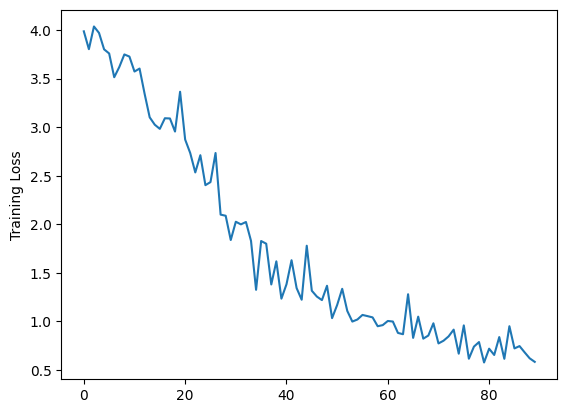

In [37]:
import matplotlib.pyplot as plt

plt.plot(train_loss_values)
plt.ylabel('Training Loss')
plt.show()

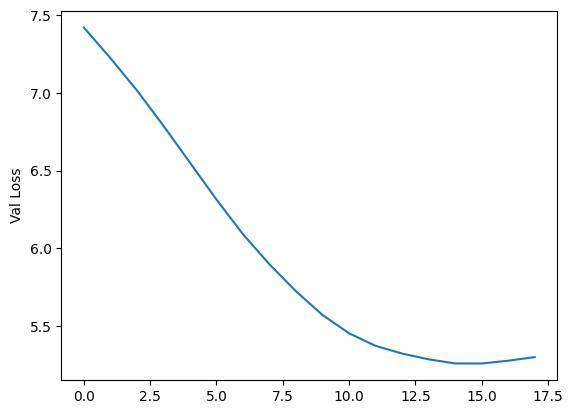

In [38]:
import matplotlib.pyplot as plt

plt.plot(valid_loss_values)
plt.ylabel('Val Loss')
plt.show()

In [39]:
import pickle

with open("val_loss.pkl", "wb") as f:
    pickle.dump({"loss": 5.3}, f)

In [43]:
torch.save(model, "model.pt")

In [40]:
a = torch.randn(8, 5)
b = nn.Linear(5, 128)

b(a).shape

torch.Size([8, 128])